In [1]:
import numpy as np
from librosa.core import stft
import matplotlib.pyplot as plt
from librosa.filters import mel

from time import time
from tqdm import tqdm

# Gerring data

In [2]:
data = np.load('./numpy_version/musicnet.npz', encoding='bytes')

# split our dataset into train and test
test_data = ['2303','2382','1819']
train_data = [f for f in data.files if f not in test_data] # Getting only the index

# Loading waveform
window = 16384
X_list = []
for train_idx in tqdm(train_data):
    X_list.append(data[train_idx][:window]) # Cutting clips to only the first 16384 samples
    


100%|██████████| 327/327 [04:18<00:00,  1.11s/it]


In [3]:
X = np.array(X_list)

In [ ]:
np.save("376_cropped_clips",X)

# Librosa

In [365]:
MelSpec_list = []
S_stft_list = []
start = time()
for song in data:
    S_stft = np.abs(stft(song, hop_length=512, n_fft=2048,center=False))
    mel_basis = mel(44100, 2048)
    MelSpec = np.dot(mel_basis, S_stft**2)
    MelSpec_list.append(MelSpec)
    S_stft_list.append(S_stft)
print("Processing finished, {0:.3f}s used".format(time()-start))

ParameterError: data must be of type numpy.ndarray

Text(0.5, 1.0, 'Mel Spec output')

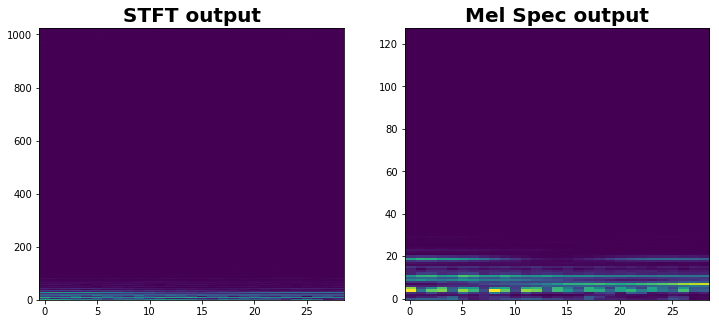

In [5]:
img_idx = 1

fig, ax = plt.subplots(1,2, figsize=(12,5))
# ax[0].plot(S_stft)
ax[0].imshow(S_stft_list[img_idx], aspect="auto")
ax[0].invert_yaxis()
ax[0].set_title("STFT output", size=20, fontweight="bold")

# ax[1].plot(MelSpec)
ax[1].imshow(MelSpec_list[img_idx], aspect="auto")
ax[1].invert_yaxis()
ax[1].set_title("Mel Spec output", size=20, fontweight="bold")

# Pytorch

In [361]:
import torch
from torch.autograd import Variable
from torch.nn.functional import conv1d

from scipy.signal.windows import hann

stride = 512
n_fft = 2048
sr = 44100


def create_filters(d,k,low=50,high=6000):
    x = np.arange(0, d, 1)
    wsin = np.empty((k,1,d), dtype=np.float32)
    wcos = np.empty((k,1,d), dtype=np.float32)
    start_freq = low
    end_freq = high
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k

    window_mask = hann(2048, sym=False) # same as 0.5-0.5*np.cos(2*np.pi*x/(k))
    for ind in range(k):
        wsin[ind,0,:] = window_mask*np.sin(2*np.pi*ind/k*x)
        wcos[ind,0,:] = window_mask*np.cos(2*np.pi*ind/k*x)

    return wsin,wcos

wsin, wcos = create_filters(2048,2048)

In [362]:
start = time()
wsin_var = Variable(torch.from_numpy(wsin), requires_grad=False)
wcos_var = Variable(torch.from_numpy(wcos),requires_grad=False)


batch_size = data.shape[0]
network_input = torch.from_numpy(data).float()
network_input = network_input.reshape(batch_size,-1)

mel_basis = mel(sr=sr, n_fft=n_fft)

sin_component = conv1d(network_input[:,None,:], wsin_var, stride=stride).pow(2)
cos_component = conv1d(network_input[:,None,:], wcos_var, stride=stride).pow(2)

zx = sin_component + cos_component # equalavent to np.abs(fft(x))

torch_mel_basis = torch.from_numpy(mel_basis).float() # Need to think how to implement it natively inside pytorch
torch_MelSpec = torch.matmul(torch_mel_basis, zx.reshape(batch_size,n_fft,-1)[:,:n_fft//2+1]**2) # Need to figure out 3D tensor operation

pytorch_Xs = zx.cpu().numpy()
print("Processing finished, {0:.3f}s used".format(time()-start))

Processing finished, 0.159s used


Text(0.5, 1.0, 'Mel Spec output')

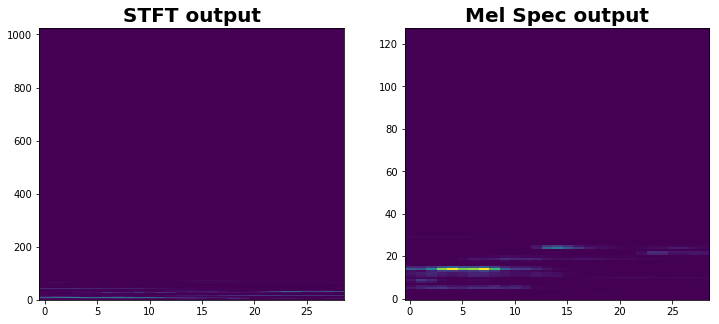

In [363]:
img_idx = 0

fig, ax = plt.subplots(1,2, figsize=(12,5))
# ax[0].plot(pytorch_Xs[0,:1025,0])
ax[0].imshow(pytorch_Xs[img_idx,:1025,:],aspect="auto")
ax[0].set_title("STFT output", size=20, fontweight="bold")
ax[0].invert_yaxis()

# ax[1].plot(torch_MelSpec.cpu().numpy())
ax[1].imshow(torch_MelSpec[img_idx].cpu().numpy(),aspect="auto")
ax[1].invert_yaxis()
ax[1].set_title("Mel Spec output", size=20, fontweight="bold")

In [127]:
img_idx = 0

In [128]:
np.allclose(MelSpec_list[img_idx], torch_MelSpec[img_idx].cpu().numpy())

True

In [131]:
np.allclose(S_stft_list[img_idx], pytorch_Xs[img_idx,:1025,:], atol=1e-5)

True